In [1]:
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



class Adaptation (nn.Module):
    def __init__(self,input):
        super().__init__()
        self.weight_matrix = nn.Linear(input,1024,bias=False)
  


    def forward(self,x):
        x = self.weight_matrix(x)
        x = torch.relu(x)
        
        return x


def sim_matrix(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt


**Fonction de calcul de la loss**

---



In [2]:
def calc_loss(left,right,temp):
  sim1 = sim_matrix(left, right)
  sim2 = sim1.t()
  loss_left2right= F.cross_entropy(sim1* temp, torch.arange(len(sim1)).long().to(device)).to(device)
  loss_right2left= F.cross_entropy(sim2* temp, torch.arange(len(sim2)).long().to(device)).to(device)
  loss = loss_left2right* 0.5 + loss_right2left * 0.5
  return loss

**Calcul top K**

In [3]:
def get_topk2(left,right, k):
  sim = -sim_matrix(left, right)
  
  sorted_idx = sim.argsort(1)
  
 
  sens1 = np.array([lbl in sorted_idx[lbl][:k] for lbl in range(len(left))])    
  sim = sim.t()
  sorted_idx = sim.argsort(1)
  sens2 = np.array([lbl in sorted_idx[lbl][:k] for lbl in range(len(left))])

  return ((sens1 | sens2).mean())

In [41]:
def load_embeddings (path): 
  data = np.load(path, allow_pickle=True).reshape(-1)[0]
  return data



In [5]:
from sklearn.preprocessing import normalize as l2

In [ ]:
left = l2(left)
right = l2(right)

Train avec zero_grad()

In [49]:
def train1(left_train, right_train, left_tst, right_tst,epochs,adaptation, optimizer,k,temp):

   
    score =0
    recall = []
    train_losses =[]
    test_losses=[]
    total_train = len(left_train)
    total_test = len(left_tst)
    for epoch in tqdm(range(epochs)):

  
        adaptation.train()
        running_loss =0.0
        optimizer.zero_grad()
        left_adapted = adaptation(left_train)
        right_adapted = adaptation(right_train)
        loss = calc_loss(left_adapted,right_adapted,temp)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()    
        with torch.no_grad():
          adaptation.eval()
          test_loss=0.0
          left_adapted_test = adaptation(left_tst)
          right_adapted_test = adaptation(right_tst)
          loss = calc_loss(left_adapted_test,right_adapted_test,temp)
          test_loss = loss.item()

        
        recall.append(get_topk2(left_adapted_test,right_adapted_test,k))
        train_losses.append(running_loss)
        test_losses.append(test_loss)
        print("Epoch " , (epoch+1))
        print("Train Loss: ",running_loss)
        print("Test Loss: ",test_loss)
        print("Recall :", recall[epoch])
        
        
    
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Testing loss')
    plt.legend()
    plt.show()
    plt.figure(1)
    plt.plot(recall,label ='Recall' )
    plt.legend()
    plt.show


Train en accumulant le gradient

In [48]:
def train2(left_train, right_train, left_tst, right_tst,epochs,adaptation, optimizer,k,temp):

   
    score =0
    recall = []    
    train_losses =[]
    test_losses=[]
    total_train = len(left_train)
    total_test = len(left_tst)
    for epoch in tqdm(range(epochs)):

  
        adaptation.train()
        running_loss =0.0
       
        left_adapted = adaptation(left_train)
        right_adapted = adaptation(right_train)
        loss = calc_loss(left_adapted,right_adapted,temp)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()    
        with torch.no_grad():
          adaptation.eval()
          test_loss=0.0
          left_adapted_test = adaptation(left_tst)
          right_adapted_test = adaptation(right_tst)
          loss = calc_loss(left_adapted_test,right_adapted_test,temp)
          test_loss = loss.item()

        
        recall.append(get_topk2(left_adapted_test,right_adapted_test,k))
        train_losses.append(running_loss)
        test_losses.append(test_loss)
        print("Epoch " , (epoch+1))
        print("Train Loss: ",running_loss)
        print("Test Loss: ",test_loss)
        print("Recall :", recall[epoch])
        
        
    print(sum(recall)/len(recall))
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Testing loss')
    plt.legend()
    plt.show()
    plt.figure(1)
    plt.plot(recall,label ='Recall' )
    plt.legend()
    plt.show

In [47]:
def run(path,runs,epochs, k,temp,type,spl):

  """
  runs : number of experiments 
  left, right : embeddings
  epochs : number of epochs 
  k : aR@k
  temp : temperature
  type : gradient accumulation =>2 
          else => 1 
  spl : train size
  """
  data = load_embeddings (path)
  if not check_embeddings(data):
    return
  left = data['left']
  right = data['right']
  left = torch.FloatTensor(left).to(device)
  right = torch.FloatTensor(right).to(device)
  #pca = PCA(256).fit(np.concatenate([left, right]))
  #left = pca.transform(left)
  #right = pca.transform(right)
  for i in range(runs):

    
    N = len(left)
    sample = int(spl*N)
    idx = np.random.permutation(left.shape[0])  
    train_idx, test_idx = idx[:sample], idx[sample:]

    model = Adaptation(256)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr =0.0005,weight_decay=1e-5)



    left_train, left_test, right_train, right_test = left[train_idx,:], left[test_idx,:], right[train_idx,], right[test_idx,]
    if type==1:
      train1(left_train,right_train,left_test, right_test,epochs, model, optimizer,k,temp)
    else:
      train2(left_train,right_train,left_test, right_test,epochs, model, optimizer,k,temp) 
  

  return{"left_train": model(left_train), "right_train" : model(right_train), "left_test": model(left_test), "right_test": model(right_test)}




Epoch  1
Train Loss:  6.895463466644287
Test Loss:  5.575901031494141
Recall : 0.17142857142857143
Epoch  2
Train Loss:  6.815420627593994
Test Loss:  5.532136917114258
Recall : 0.1761904761904762
Epoch  3
Train Loss:  6.736627578735352
Test Loss:  5.489441871643066
Recall : 0.1761904761904762
Epoch  4
Train Loss:  6.659130096435547
Test Loss:  5.447847366333008
Recall : 0.17714285714285713
Epoch  5
Train Loss:  6.5829572677612305
Test Loss:  5.40738582611084
Recall : 0.18
Epoch  6
Train Loss:  6.508173942565918
Test Loss:  5.368088722229004
Recall : 0.18285714285714286
Epoch  7
Train Loss:  6.4348015785217285
Test Loss:  5.329928398132324
Recall : 0.18476190476190477
Epoch  8
Train Loss:  6.36283540725708
Test Loss:  5.292901039123535
Recall : 0.18857142857142858
Epoch  9
Train Loss:  6.292285442352295
Test Loss:  5.256989479064941
Recall : 0.19142857142857142
Epoch  10
Train Loss:  6.223156929016113
Test Loss:  5.222175598144531
Recall : 0.1961904761904762
Epoch  11
Train Loss:  6.15

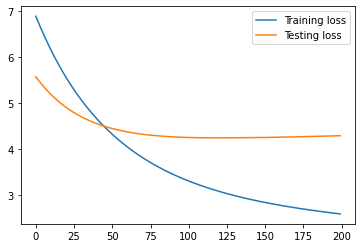

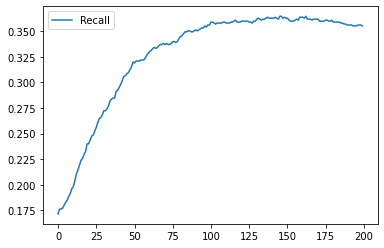

In [ ]:
run(path="pairs_ebds.npy",runs=1,epochs=200,k=1,temp=15,type=1,spl=0.75)

Sans pca

Epoch  1
Train Loss:  7.194338798522949
Test Loss:  6.0058393478393555
Recall : 0.1523809523809524
Epoch  2
Train Loss:  7.039216995239258
Test Loss:  5.875629425048828
Recall : 0.16
Epoch  3
Train Loss:  6.882340431213379
Test Loss:  5.750176429748535
Recall : 0.16857142857142857
Epoch  4
Train Loss:  6.727581977844238
Test Loss:  5.632506370544434
Recall : 0.1761904761904762
Epoch  5
Train Loss:  6.578578948974609
Test Loss:  5.52464485168457
Recall : 0.18095238095238095
Epoch  6
Train Loss:  6.4367265701293945
Test Loss:  5.427233695983887
Recall : 0.18857142857142858
Epoch  7
Train Loss:  6.302309989929199
Test Loss:  5.339616775512695
Recall : 0.19238095238095237
Epoch  8
Train Loss:  6.174553871154785
Test Loss:  5.260492324829102
Recall : 0.1980952380952381
Epoch  9
Train Loss:  6.052165508270264
Test Loss:  5.188616752624512
Recall : 0.20285714285714285
Epoch  10
Train Loss:  5.933440208435059
Test Loss:  5.123050689697266
Recall : 0.20857142857142857
Epoch  11
Train Loss:  5.8

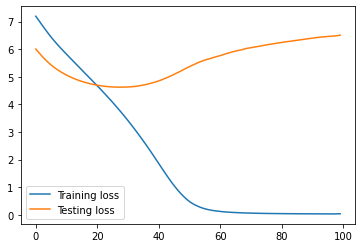

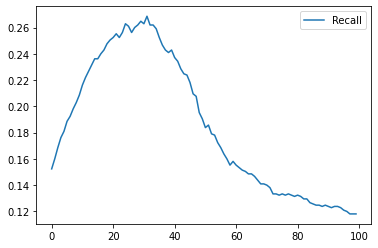

In [ ]:
run(path="pairs_ebds.npy",runs=1,epochs=100,k=1,temp=15,type=1,spl=0.75)

Epoch  1
Train Loss:  6.885959625244141
Test Loss:  5.815744400024414
Recall : 0.14285714285714285
Epoch  2
Train Loss:  6.806159019470215
Test Loss:  5.768312454223633
Recall : 0.14285714285714285
Epoch  3
Train Loss:  6.727612495422363
Test Loss:  5.721988201141357
Recall : 0.1457142857142857
Epoch  4
Train Loss:  6.650341033935547
Test Loss:  5.676858425140381
Recall : 0.14761904761904762
Epoch  5
Train Loss:  6.574367523193359
Test Loss:  5.632936477661133
Recall : 0.14857142857142858
Epoch  6
Train Loss:  6.499733924865723
Test Loss:  5.590239524841309
Recall : 0.1523809523809524
Epoch  7
Train Loss:  6.426479339599609
Test Loss:  5.548733711242676
Recall : 0.1523809523809524
Epoch  8
Train Loss:  6.354615211486816
Test Loss:  5.508426666259766
Recall : 0.15714285714285714
Epoch  9
Train Loss:  6.2841291427612305
Test Loss:  5.469315528869629
Recall : 0.16
Epoch  10
Train Loss:  6.215026378631592
Test Loss:  5.431362628936768
Recall : 0.16380952380952382
Epoch  11
Train Loss:  6.1

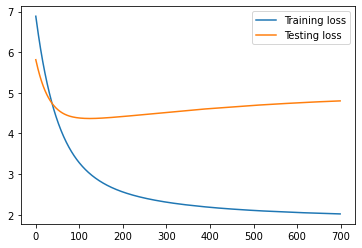

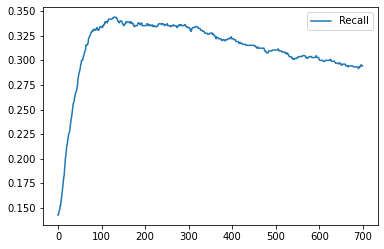

In [ ]:
run(path="pairs_ebds.npy",runs=1,epochs=700,k=1,temp=15,type=1,spl=0.75)

Epoch  1
Train Loss:  6.87333869934082
Test Loss:  5.691632270812988
Recall : 0.1580952380952381
Epoch  2
Train Loss:  6.793310165405273
Test Loss:  5.648541450500488
Recall : 0.16380952380952382
Epoch  3
Train Loss:  6.717205047607422
Test Loss:  5.606600761413574
Recall : 0.16952380952380952
Epoch  4
Train Loss:  6.642841339111328
Test Loss:  5.565454006195068
Recall : 0.17142857142857143
Epoch  5
Train Loss:  6.569545745849609
Test Loss:  5.52495813369751
Recall : 0.1742857142857143
Epoch  6
Train Loss:  6.497056007385254
Test Loss:  5.485079288482666
Recall : 0.17904761904761904
Epoch  7
Train Loss:  6.425285816192627
Test Loss:  5.445823669433594
Recall : 0.18285714285714286
Epoch  8
Train Loss:  6.354207992553711
Test Loss:  5.407211780548096
Recall : 0.1838095238095238
Epoch  9
Train Loss:  6.283816337585449
Test Loss:  5.369265556335449
Recall : 0.18666666666666668
Epoch  10
Train Loss:  6.214180946350098
Test Loss:  5.332015514373779
Recall : 0.19047619047619047
Epoch  11
Trai

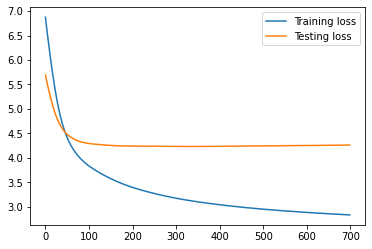

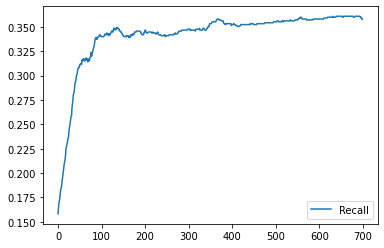

In [ ]:
run(path="pairs_ebds.npy",runs=1,epochs=700,k=1,temp=15,type=2,spl=0.75)

Epoch  1
Train Loss:  7.439766883850098
Test Loss:  6.2475361824035645
Recall : 0.12476190476190477
Epoch  2
Train Loss:  7.370005130767822
Test Loss:  6.216598987579346
Recall : 0.12476190476190477
Epoch  3
Train Loss:  7.301321506500244
Test Loss:  6.186524391174316
Recall : 0.12380952380952381
Epoch  4
Train Loss:  7.233725547790527
Test Loss:  6.1573872566223145
Recall : 0.1219047619047619
Epoch  5
Train Loss:  7.167269706726074
Test Loss:  6.1291656494140625
Recall : 0.12380952380952381
Epoch  6
Train Loss:  7.101993083953857
Test Loss:  6.1018595695495605
Recall : 0.12476190476190477
Epoch  7
Train Loss:  7.03794002532959
Test Loss:  6.075542449951172
Recall : 0.12380952380952381
Epoch  8
Train Loss:  6.975141525268555
Test Loss:  6.0502142906188965
Recall : 0.1295238095238095
Epoch  9
Train Loss:  6.9136199951171875
Test Loss:  6.025838851928711
Recall : 0.1295238095238095
Epoch  10
Train Loss:  6.853377342224121
Test Loss:  6.0024003982543945
Recall : 0.1295238095238095
Epoch  

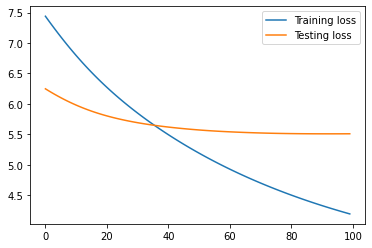

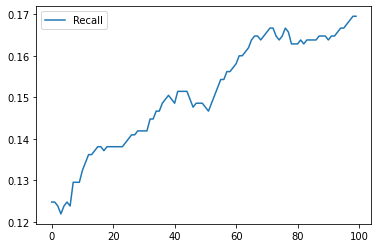

In [ ]:
run(path="resnet18.npy",runs=1,epochs=100,k=1,temp=15,k=1,spl=0.75)

Epoch  1
Train Loss:  7.4062628746032715
Test Loss:  6.331142425537109
Recall : 0.11714285714285715
Epoch  2
Train Loss:  7.337254524230957
Test Loss:  6.299615859985352
Recall : 0.11714285714285715
Epoch  3
Train Loss:  7.271571159362793
Test Loss:  6.268995761871338
Recall : 0.1180952380952381
Epoch  4
Train Loss:  7.2073469161987305
Test Loss:  6.239062786102295
Recall : 0.1180952380952381
Epoch  5
Train Loss:  7.143993377685547
Test Loss:  6.209712028503418
Recall : 0.11619047619047619
Epoch  6
Train Loss:  7.08131217956543
Test Loss:  6.180895805358887
Recall : 0.11619047619047619
Epoch  7
Train Loss:  7.019209384918213
Test Loss:  6.15268087387085
Recall : 0.1180952380952381
Epoch  8
Train Loss:  6.957712650299072
Test Loss:  6.125058174133301
Recall : 0.11904761904761904
Epoch  9
Train Loss:  6.896842002868652
Test Loss:  6.098074436187744
Recall : 0.11904761904761904
Epoch  10
Train Loss:  6.836660385131836
Test Loss:  6.071798801422119
Recall : 0.11904761904761904
Epoch  11
Tr

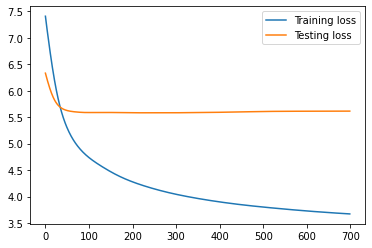

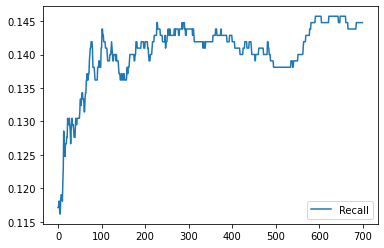

In [ ]:
run(path="resnet18.npy",runs=1,epochs=700,k=1,temp=15,type=2,spl=0.75)

Epoch  1
Train Loss:  7.466360092163086
Test Loss:  6.267712593078613
Recall : 0.11523809523809524
Epoch  2
Train Loss:  7.392768859863281
Test Loss:  6.226260185241699
Recall : 0.11714285714285715
Epoch  3
Train Loss:  7.320338249206543
Test Loss:  6.185888290405273
Recall : 0.1180952380952381
Epoch  4
Train Loss:  7.2491068840026855
Test Loss:  6.146666526794434
Recall : 0.11904761904761904
Epoch  5
Train Loss:  7.17912483215332
Test Loss:  6.108649253845215
Recall : 0.11904761904761904
Epoch  6
Train Loss:  7.110443115234375
Test Loss:  6.071834564208984
Recall : 0.12
Epoch  7
Train Loss:  7.043105125427246
Test Loss:  6.036253452301025
Recall : 0.12095238095238095
Epoch  8
Train Loss:  6.977138519287109
Test Loss:  6.001908302307129
Recall : 0.1219047619047619
Epoch  9
Train Loss:  6.912550926208496
Test Loss:  5.968816757202148
Recall : 0.12285714285714286
Epoch  10
Train Loss:  6.849364757537842
Test Loss:  5.936989784240723
Recall : 0.12571428571428572
Epoch  11
Train Loss:  6.7

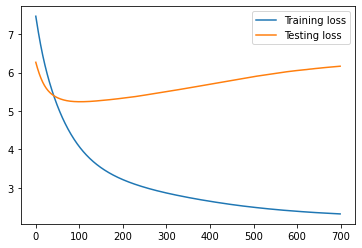

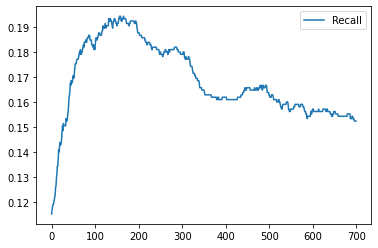

In [ ]:
run(path="resnet50.npy",runs=1,epochs=700,k=1,temp=15,type=1,spl=0.75)

Epoch  1
Train Loss:  7.422816276550293
Test Loss:  6.260641098022461
Recall : 0.12285714285714286
Epoch  2
Train Loss:  7.349076271057129
Test Loss:  6.221037864685059
Recall : 0.12095238095238095
Epoch  3
Train Loss:  7.278962135314941
Test Loss:  6.182674407958984
Recall : 0.12
Epoch  4
Train Loss:  7.210482120513916
Test Loss:  6.145260810852051
Recall : 0.12095238095238095
Epoch  5
Train Loss:  7.143012523651123
Test Loss:  6.108663558959961
Recall : 0.1219047619047619
Epoch  6
Train Loss:  7.076333045959473
Test Loss:  6.072834014892578
Recall : 0.12285714285714286
Epoch  7
Train Loss:  7.010381698608398
Test Loss:  6.037796974182129
Recall : 0.12666666666666668
Epoch  8
Train Loss:  6.94518518447876
Test Loss:  6.003628253936768
Recall : 0.12857142857142856
Epoch  9
Train Loss:  6.880763053894043
Test Loss:  5.970354080200195
Recall : 0.12761904761904763
Epoch  10
Train Loss:  6.817169666290283
Test Loss:  5.938026428222656
Recall : 0.12666666666666668
Epoch  11
Train Loss:  6.7

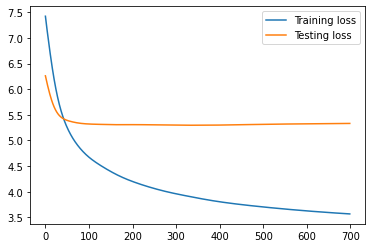

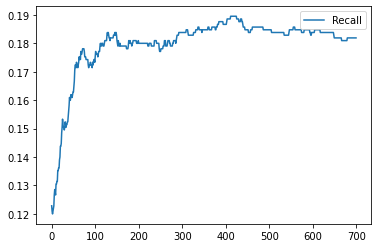

In [ ]:
run(path="resnet50.npy",runs=1,epochs=700,k=1,temp=15,type=2,spl=0.75)

Epoch  1
Train Loss:  7.465764999389648
Test Loss:  6.306556224822998
Recall : 0.11238095238095239
Epoch  2
Train Loss:  7.393074035644531
Test Loss:  6.2659196853637695
Recall : 0.11142857142857143
Epoch  3
Train Loss:  7.321505546569824
Test Loss:  6.226320266723633
Recall : 0.11142857142857143
Epoch  4
Train Loss:  7.251111030578613
Test Loss:  6.18784236907959
Recall : 0.11333333333333333
Epoch  5
Train Loss:  7.1819562911987305
Test Loss:  6.150552749633789
Recall : 0.11428571428571428
Epoch  6
Train Loss:  7.114090442657471
Test Loss:  6.1144561767578125
Recall : 0.11714285714285715
Epoch  7
Train Loss:  7.047557830810547
Test Loss:  6.079598426818848
Recall : 0.1180952380952381
Epoch  8
Train Loss:  6.982392311096191
Test Loss:  6.045991897583008
Recall : 0.1180952380952381
Epoch  9
Train Loss:  6.918620586395264
Test Loss:  6.013633728027344
Recall : 0.11904761904761904
Epoch  10
Train Loss:  6.856264114379883
Test Loss:  5.982527732849121
Recall : 0.11904761904761904
Epoch  11

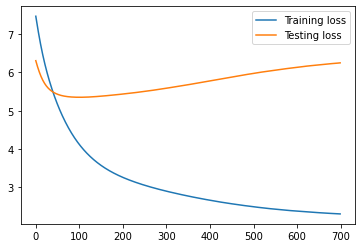

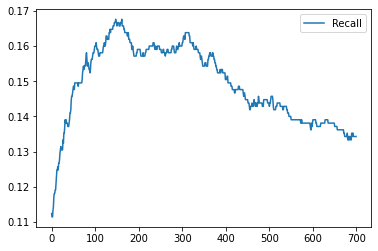

In [ ]:
run(path="resnet101.npy",runs=1,epochs=700,k=1,temp=15,type=1,spl=0.75)

Epoch  1
Train Loss:  7.515873432159424
Test Loss:  6.253229141235352
Recall : 0.1180952380952381
Epoch  2
Train Loss:  7.44246768951416
Test Loss:  6.214075088500977
Recall : 0.12095238095238095
Epoch  3
Train Loss:  7.372601509094238
Test Loss:  6.176089286804199
Recall : 0.12476190476190477
Epoch  4
Train Loss:  7.3042802810668945
Test Loss:  6.139005661010742
Recall : 0.12380952380952381
Epoch  5
Train Loss:  7.236928939819336
Test Loss:  6.102731704711914
Recall : 0.12476190476190477
Epoch  6
Train Loss:  7.170311450958252
Test Loss:  6.067212104797363
Recall : 0.12380952380952381
Epoch  7
Train Loss:  7.10438346862793
Test Loss:  6.032499313354492
Recall : 0.12666666666666668
Epoch  8
Train Loss:  7.039150238037109
Test Loss:  5.998648643493652
Recall : 0.12666666666666668
Epoch  9
Train Loss:  6.974661350250244
Test Loss:  5.965672969818115
Recall : 0.12761904761904763
Epoch  10
Train Loss:  6.910962104797363
Test Loss:  5.933601379394531
Recall : 0.12857142857142856
Epoch  11
T

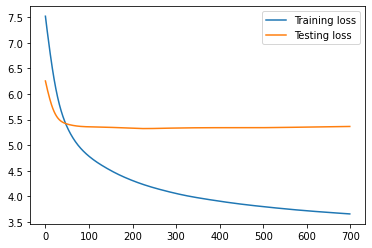

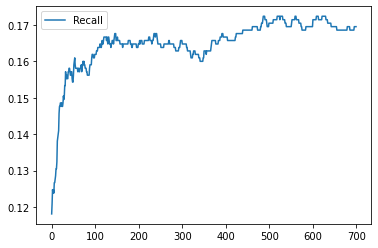

In [ ]:
run(path="resnet101.npy",runs=1,epochs=700,k=1,temp=15,type=2,spl=0.75)

Epoch  1
Train Loss:  7.471701622009277
Test Loss:  6.384171485900879
Recall : 0.11428571428571428
Epoch  2
Train Loss:  7.397970199584961
Test Loss:  6.34316349029541
Recall : 0.11714285714285715
Epoch  3
Train Loss:  7.325364112854004
Test Loss:  6.30318546295166
Recall : 0.11714285714285715
Epoch  4
Train Loss:  7.253933429718018
Test Loss:  6.264240741729736
Recall : 0.11904761904761904
Epoch  5
Train Loss:  7.183741092681885
Test Loss:  6.22642707824707
Recall : 0.12095238095238095
Epoch  6
Train Loss:  7.114833831787109
Test Loss:  6.189775466918945
Recall : 0.12380952380952381
Epoch  7
Train Loss:  7.047266006469727
Test Loss:  6.154356956481934
Recall : 0.1219047619047619
Epoch  8
Train Loss:  6.9810943603515625
Test Loss:  6.120136260986328
Recall : 0.12571428571428572
Epoch  9
Train Loss:  6.9163384437561035
Test Loss:  6.087116241455078
Recall : 0.12476190476190477
Epoch  10
Train Loss:  6.852999687194824
Test Loss:  6.055340766906738
Recall : 0.12761904761904763
Epoch  11
T

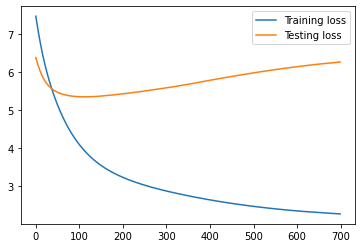

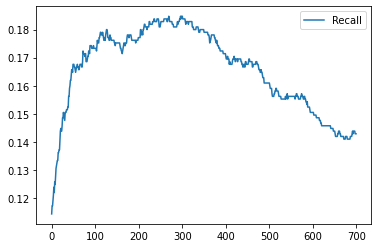

In [ ]:
run(path="resnet152.npy",runs=1,epochs=700,k=1,temp=15,type=1,spl=0.75)

Epoch  1
Train Loss:  7.44481086730957
Test Loss:  6.324102401733398
Recall : 0.12
Epoch  2
Train Loss:  7.372014999389648
Test Loss:  6.285968780517578
Recall : 0.12095238095238095
Epoch  3
Train Loss:  7.302770614624023
Test Loss:  6.248893737792969
Recall : 0.12285714285714286
Epoch  4
Train Loss:  7.235110282897949
Test Loss:  6.212578773498535
Recall : 0.12476190476190477
Epoch  5
Train Loss:  7.168423652648926
Test Loss:  6.176889896392822
Recall : 0.12476190476190477
Epoch  6
Train Loss:  7.102505207061768
Test Loss:  6.14178466796875
Recall : 0.12380952380952381
Epoch  7
Train Loss:  7.037295341491699
Test Loss:  6.107322692871094
Recall : 0.12666666666666668
Epoch  8
Train Loss:  6.972789764404297
Test Loss:  6.073550224304199
Recall : 0.13047619047619047
Epoch  9
Train Loss:  6.909060478210449
Test Loss:  6.040458679199219
Recall : 0.13333333333333333
Epoch  10
Train Loss:  6.84616231918335
Test Loss:  6.008126258850098
Recall : 0.13238095238095238
Epoch  11
Train Loss:  6.78

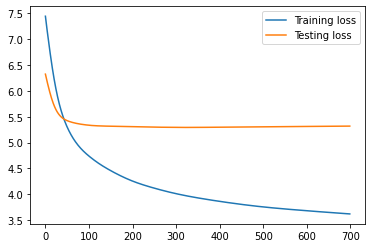

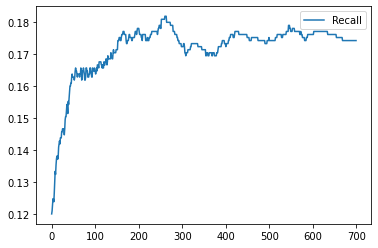

In [ ]:
run(path="resnet152.npy",runs=1,epochs=700,k=1,temp=15,type=2,spl=0.75)

Epoch  1
Train Loss:  7.439854145050049
Test Loss:  6.318024635314941
Recall : 0.11904761904761904
Epoch  2
Train Loss:  7.367676734924316
Test Loss:  6.281444549560547
Recall : 0.12095238095238095
Epoch  3
Train Loss:  7.296570777893066
Test Loss:  6.245761871337891
Recall : 0.12285714285714286
Epoch  4
Train Loss:  7.2265825271606445
Test Loss:  6.21104621887207
Recall : 0.12666666666666668
Epoch  5
Train Loss:  7.157779216766357
Test Loss:  6.1773786544799805
Recall : 0.12761904761904763
Epoch  6
Train Loss:  7.090193748474121
Test Loss:  6.144777297973633
Recall : 0.12761904761904763
Epoch  7
Train Loss:  7.023855209350586
Test Loss:  6.113231182098389
Recall : 0.12666666666666668
Epoch  8
Train Loss:  6.958826065063477
Test Loss:  6.082775115966797
Recall : 0.12761904761904763
Epoch  9
Train Loss:  6.895119667053223
Test Loss:  6.053440093994141
Recall : 0.12761904761904763
Epoch  10
Train Loss:  6.832751750946045
Test Loss:  6.025219440460205
Recall : 0.12857142857142856
Epoch  1

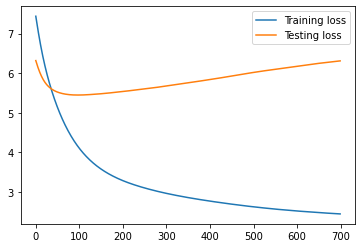

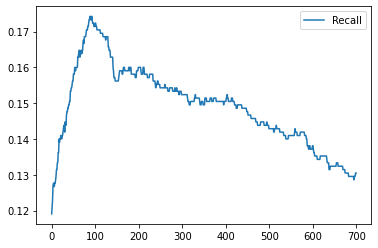

In [ ]:
run(path="resnet34.npy",runs=1,epochs=700,k=1,temp=15,type=1,spl=0.75)

Epoch  1
Train Loss:  7.423356056213379
Test Loss:  6.325618743896484
Recall : 0.12095238095238095
Epoch  2
Train Loss:  7.3509979248046875
Test Loss:  6.289604187011719
Recall : 0.12380952380952381
Epoch  3
Train Loss:  7.282127380371094
Test Loss:  6.254668235778809
Recall : 0.12761904761904763
Epoch  4
Train Loss:  7.214826583862305
Test Loss:  6.220484733581543
Recall : 0.12761904761904763
Epoch  5
Train Loss:  7.148494243621826
Test Loss:  6.186999320983887
Recall : 0.12857142857142856
Epoch  6
Train Loss:  7.082928657531738
Test Loss:  6.1541428565979
Recall : 0.12857142857142856
Epoch  7
Train Loss:  7.0180277824401855
Test Loss:  6.121931076049805
Recall : 0.12857142857142856
Epoch  8
Train Loss:  6.9537811279296875
Test Loss:  6.090396881103516
Recall : 0.12857142857142856
Epoch  9
Train Loss:  6.890247344970703
Test Loss:  6.059609413146973
Recall : 0.13047619047619047
Epoch  10
Train Loss:  6.827498435974121
Test Loss:  6.029677391052246
Recall : 0.13142857142857142
Epoch  1

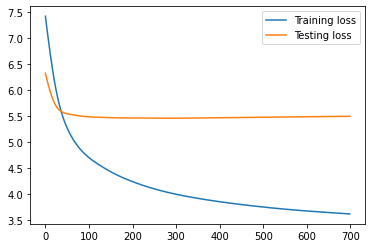

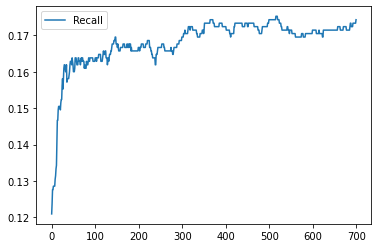

In [ ]:
run(path="resnet34.npy",runs=1,epochs=700,k=1,temp=15,type=2,spl=0.75)

In [ ]:
torch.save(result,"visual_ebds.pth")